In [3]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import preprocessing
import os
import urllib.request
import pandas as pd 
from random import randint
import transforms

In [4]:
path = os.getcwd()+'\\All_with_Saldo.csv'

In [5]:
df = pd.read_csv(path, delimiter=';',  low_memory=False)
df = df.drop(columns= ['Datum', 'Zeit','SpotVol'])
df = df.iloc[69000:,0:21]
df.head()

rebap  nrv_saldo  Intraday_Price  Intraday_Volume  SpotPrice  \
69000  59.95    301.032           72.82            264.2      74.97   
69001  59.95    110.623           67.98            391.1      74.97   
69002  59.95     68.567           68.68            393.5      74.97   
69003  47.96    370.162           66.48            595.8      57.56   
69004  47.96    400.808           59.36            238.8      57.56   

       pv50HerzMW  wind50HerzMW  pvAmperion  windAmperion  pvTransnetBW  ...  \
69000           0      3843.845         0.0           505             0  ...   
69001           0      4044.654         0.0           532             0  ...   
69002           0      4164.637         0.0           546             0  ...   
69003           0      4228.572         0.0           535             0  ...   
69004           0      4267.860         0.0           545             0  ...   

       pvTenneT  windTenneT  pv_50HerzProjection  wind_50HerzProjection  \
69000       0.0      3048.7                  0.0               2761.662   
69001       0.0      3241.9                  0.0               2819.371   
69002       0.0      3230.7                  0.0               2877.110   
69003       0.0      3232.0                  0.0               2916.211   
69004       0.0      3071.5                  0.0               2918.324   

       pv_amperionProjection  wind_amperionProjection  \
69000                      0                      249   
69001                      0                      245   
69002                      0                      248   
69003                      0                      248   
69004                      0                      244   

       pv_transnetBWProjection  wind_transnetBWProjection  \
69000                        0                         13   
69001                        0                         13   
69002                        0                         13   
69003                        0                         13   
69004                        0                         13   

       wind_tennetProjection  pv_tennetProjection  
69000                 2696.0                  0.0  
69001                 2690.0                  0.0  
69002                 2689.0                  0.0  
69003                 2683.0                  0.0  
69004                 2662.0                  0.0  

[5 rows x 21 columns]

In [2]:
scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df.values))

NameError: name 'preprocessing' is not defined

In [14]:
trainX,trainY = transforms.multivariate_data( df.iloc[1000:,1:].values,df.iloc[1000:,0].values, 0,None,history_size=192,target_size=96,step=1)
valX,valY = transforms.multivariate_data( df.iloc[:999,1:].values,df.iloc[:999,0].values, 0,None,history_size=192,target_size=96,step=1)

print ('Single window of past history : {}'.format(trainX[0].shape))
print ('\n Target to predict : {}'.format(trainY[0].shape))


Single window of past history : (192, 20)

 Target to predict : (96,)


In [15]:
trainX = trainX[:82800]
trainY = trainY[:82800]

In [16]:
train = tf.data.Dataset.from_tensor_slices((trainX,trainY))
val = tf.data.Dataset.from_tensor_slices((valX,valY))

In [55]:
BATCH_SIZE = 2
train = train.cache().batch(BATCH_SIZE).repeat()
val = val.cache().batch(BATCH_SIZE).repeat()

In [18]:
def rmseLoss(targets, outputs):
    return tf.sqrt(tf.reduce_mean((targets - outputs)**2))

In [19]:
(trainX.shape[-2:])

(192, 20)

In [53]:
model  = tf.keras.models.Sequential()
model.add(keras.layers.LSTM(192, activation='tanh', return_sequences=False, input_shape=(trainX.shape[-2:])))
model.add(keras.layers.Dense(96))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [1]:
with tf.device('/CPU:0'):
    model.fit(train,epochs=2, validation_data=val,validation_steps=30, steps_per_epoch=100)

NameError: name 'tf' is not defined

In [36]:
predictions = model.predict(valX[:])

In [32]:
predictions[1]

array([ 8.903047 ,  9.363451 ,  9.102613 ,  9.722543 ,  9.264054 ,
       10.112467 ,  9.032052 ,  9.295175 , 10.3820915,  8.663829 ,
        9.24236  ,  9.490792 ,  9.314584 , 10.984089 ,  9.647693 ,
        9.30085  , 10.002356 , 10.075749 ,  8.29849  , 10.004348 ,
        8.924856 , 10.683526 ,  7.7868247,  9.351578 ,  9.600715 ,
        9.6819   ,  7.9624033,  9.243192 ,  9.691361 ,  9.657275 ,
        9.413659 ,  9.243476 , 10.077195 , 11.27731  , 10.212955 ,
        9.940972 , 11.783863 ,  9.978817 ,  9.712428 ,  8.613415 ,
       10.581934 ,  9.158876 ,  8.972532 , 10.024015 ,  9.024215 ,
       10.025211 , 10.002008 , 10.045697 ,  9.360954 ,  9.494544 ,
        8.511177 , 10.154882 , 10.32959  ,  9.704584 ,  9.643897 ,
        8.891001 , 10.200646 ,  8.769664 ,  9.5562   ,  8.477909 ,
        9.003369 , 10.133636 , 10.053091 , 10.90886  ,  9.868791 ,
        9.8393955,  8.760874 ,  9.263393 ,  8.973059 ,  9.153874 ,
       10.022063 ,  9.121674 ,  9.682353 ,  8.517019 ,  8.8210

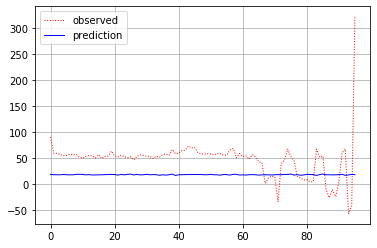

In [51]:
plt.plot(valY[8], color='red', label='observed',linestyle='dotted',linewidth=1)
plt.plot(predictions[2],color='blue', label='prediction',linewidth=1)
# plt.autoscale(enable=True, axis='both')
plt.grid()
plt.legend()
plt.show()

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()